In [27]:
import torch
from project.fer_module import FerModule  
import yaml


yaml_path = 'C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\experiments\\CKPlusDVS_0\\version_31\hparams.yaml'

# Charger le fichier YAML
with open(yaml_path, 'r') as file:
    hparams = yaml.safe_load(file)
# Chemin vers le fichier de checkpoint
checkpoint_path = 'C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\experiments\\CKPlusDVS_0\\version_31\\checkpoints\\0_epoch=717_val_acc=0.7324.ckpt'

# Charger le checkpoint
checkpoint = torch.load(checkpoint_path)
timesteps = hparams['timesteps']
learning_rate = hparams['learning_rate']
n_classes = hparams['n_classes']
epochs = hparams['epochs']
# Initialiser le modèle 
model = FerModule(learning_rate=learning_rate,timesteps=timesteps, n_classes=n_classes, epochs=epochs,mode="snn")

# Charger les poids du modèle à partir du checkpoint
model.load_state_dict(checkpoint['state_dict'])


<All keys matched successfully>

In [28]:
from torch.utils.data import DataLoader
from project.datamodules.fer_dvs import FerDVS  # Assurez-vous que le chemin d'importation est correct
from project.utils.transforms import DVSTransform  # Assurez-vous que le chemin d'importation est correct

# Instancier la transformation
transforms_list = ["flip", "background_activity", "crop", "reverse", "mirror", "event_drop"]
transform = DVSTransform(
    sensor_size=FerDVS.sensor_size,  
    timesteps=6,  # Le nombre de pas de temps 
    transforms_list=transforms_list,
    concat_time_channels="snn"  
)
# Créer une instance du Dataset en utilisant FerDVS
dataset = FerDVS(save_to="C:\\Users\\Othmane\\Desktop\\spiking-fer-master\\data",
                 dataset="CKPlusDVS",  
                 train=True,
                 fold=0,
                 transform=transform)

# Créer un DataLoader pour l'inférence
data_loader = DataLoader(dataset, batch_size=32, shuffle=False)

In [29]:
inputs = inputs.unsqueeze(1)  # Ajoute une dimension de pas de temps après la dimension du lot



In [44]:
from sklearn.metrics import confusion_matrix, classification_report
import numpy as np
from project.models.snn_models import SNNModule  

model.eval()


y_true = []
y_pred = []
model = SNNModule(in_channels=2, timesteps=hparams['timesteps'], n_classes=hparams['n_classes'])


with torch.no_grad():
    for i, (inputs, labels) in enumerate(data_loader):
        print(f"Lot {i}: Taille des entrées avant réduction des canaux: {inputs.size()} - Taille des étiquettes: {labels.size()}")


        inputs_reduced = torch.mean(inputs[:, :6, :, :], dim=1, keepdim=True)  # Moyenne des 6 premiers canaux
        inputs_reduced = torch.cat((inputs_reduced, torch.mean(inputs[:, 6:, :, :], dim=1, keepdim=True)), dim=1)  # Ajout de la moyenne des 6 derniers canaux
        print(f"Lot {i}: Taille des entrées après réduction des canaux: {inputs_reduced.size()}")

       
        if inputs_reduced.dim() == 4:  # (batch_size, channels, height, width)
            inputs_reduced = inputs_reduced.unsqueeze(0)  # Ajout d'une dimension temporelle pour SNN
        inputs_reduced = inputs_reduced.permute(1, 0, 2, 3, 4)
        outputs = model(inputs_reduced)
        print(f"Lot {i}: Taille des sorties du modèle: {outputs.size()}")

        if outputs.size(0) == inputs_reduced.size(0):
            _, predicted = torch.max(outputs, dim=1)
        
            print(f"Lot {i}: Taille des prédictions: {predicted.size()}")
            labels_flat = labels.view(-1).cpu().numpy()  # Aplatir et convertir en numpy
            predicted_flat = predicted.view(-1).cpu().numpy()
            print(f"Lot {i}: Nombre d'étiquettes aplaties: {len(labels_flat)} - Nombre de prédictions aplaties: {len(predicted_flat)}")

        else:
            print(f"Erreur dans le lot {i}: la taille de sortie du modèle ne correspond pas au lot d'entrée.")

        y_true.extend(labels_flat)
        y_pred.extend(predicted_flat)



Lot 0: Taille des entrées avant réduction des canaux: torch.Size([32, 12, 128, 128]) - Taille des étiquettes: torch.Size([32])
Lot 0: Taille des entrées après réduction des canaux: torch.Size([32, 2, 128, 128])
Lot 0: Taille des sorties du modèle: torch.Size([32, 6])
Lot 0: Taille des prédictions: torch.Size([32])
Lot 0: Nombre d'étiquettes aplaties: 32 - Nombre de prédictions aplaties: 32
Lot 1: Taille des entrées avant réduction des canaux: torch.Size([32, 12, 128, 128]) - Taille des étiquettes: torch.Size([32])
Lot 1: Taille des entrées après réduction des canaux: torch.Size([32, 2, 128, 128])
Lot 1: Taille des sorties du modèle: torch.Size([32, 6])
Lot 1: Taille des prédictions: torch.Size([32])
Lot 1: Nombre d'étiquettes aplaties: 32 - Nombre de prédictions aplaties: 32
Lot 2: Taille des entrées avant réduction des canaux: torch.Size([32, 12, 128, 128]) - Taille des étiquettes: torch.Size([32])
Lot 2: Taille des entrées après réduction des canaux: torch.Size([32, 2, 128, 128])
Lot

In [36]:
for inputs, labels in data_loader:
    print(inputs.size(), labels.size())


torch.Size([32, 12, 128, 128]) torch.Size([32])
torch.Size([32, 12, 128, 128]) torch.Size([32])
torch.Size([32, 12, 128, 128]) torch.Size([32])
torch.Size([32, 12, 128, 128]) torch.Size([32])
torch.Size([32, 12, 128, 128]) torch.Size([32])
torch.Size([32, 12, 128, 128]) torch.Size([32])
torch.Size([32, 12, 128, 128]) torch.Size([32])
torch.Size([32, 12, 128, 128]) torch.Size([32])
torch.Size([30, 12, 128, 128]) torch.Size([30])


In [26]:
print(inputs.type())

torch.FloatTensor


In [45]:

conf_matrix = confusion_matrix(y_true, y_pred)
print("Matrice de confusion :\n", conf_matrix)

print("Rapport de classification :\n", classification_report(y_true, y_pred, target_names=FerDVS.classes))

Matrice de confusion :
 [[ 3  6 23 22 12  7]
 [ 0  2 20  7 10  3]
 [ 2  5 13 22 15  2]
 [ 4  2  3 10  7  1]
 [ 2  4 12  7  6  3]
 [ 1  4 15 13 14  4]]
Rapport de classification :
               precision    recall  f1-score   support

       happy       0.25      0.04      0.07        73
        fear       0.09      0.05      0.06        42
    surprise       0.15      0.22      0.18        59
       anger       0.12      0.37      0.19        27
     disgust       0.09      0.18      0.12        34
     sadness       0.20      0.08      0.11        51

    accuracy                           0.13       286
   macro avg       0.15      0.16      0.12       286
weighted avg       0.17      0.13      0.12       286



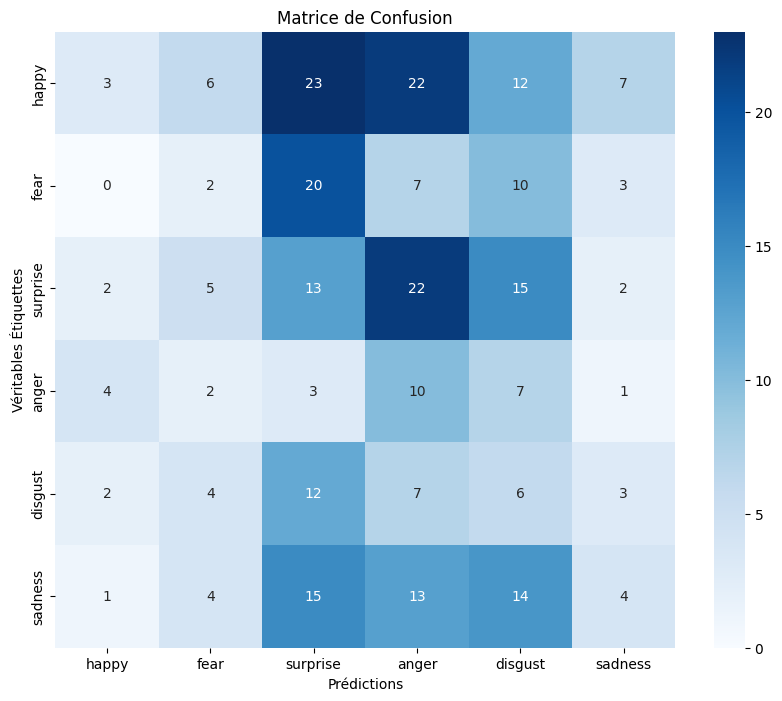

In [49]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Calculer la matrice de confusion
conf_matrix = confusion_matrix(y_true, y_pred)

# Tracer la matrice de confusion
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=FerDVS.classes, yticklabels=FerDVS.classes)
plt.xlabel('Prédictions')
plt.ylabel('Véritables Étiquettes')
plt.title('Matrice de Confusion')
plt.show()
